In [1]:
#scan.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 2 August 2020.
#inspect the output of all simulations launched by scan.py that executed in 36 hours

In [2]:
#monitor execution time
import time as tm
t_start = tm.time()

In [3]:
#get paths to all simulations
import os
parent_path = 'permutations/'
paths = os.listdir(parent_path)
#paths.remove('nothing')
paths = [parent_path + path for path in paths]
print 'number of paths = ', len(paths)
paths[0:5]

number of paths =  545


['permutations/sim_id=530!total_ring_mass=1.0000000000000007e-09!shear_viscosity=4.641588833612777e-15!bulk_viscosity=4.641588833612777e-15!radial_width=0.0001!timesteps_per_output=5735!',
 'permutations/sim_id=522!total_ring_mass=1.0000000000000007e-09!shear_viscosity=1.0000000000000013e-15!bulk_viscosity=1.0000000000000013e-15!radial_width=0.0001!timesteps_per_output=26623!',
 'permutations/sim_id=338!total_ring_mass=9.999999999999985e-12!shear_viscosity=9.999999999999999e-14!bulk_viscosity=9.999999999999999e-14!radial_width=0.0001!timesteps_per_output=166!',
 'permutations/sim_id=357!total_ring_mass=9.999999999999985e-12!shear_viscosity=4.641588833612776e-12!bulk_viscosity=4.641588833612776e-12!radial_width=5e-05!timesteps_per_output=143!',
 'permutations/sim_id=227!total_ring_mass=1.000000000000001e-12!shear_viscosity=2.154434690031887e-14!bulk_viscosity=2.154434690031887e-14!radial_width=0.0002!timesteps_per_output=3094!']

In [4]:
#prep plots
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})
color_seq = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

In [5]:
#order paths by sim_id
data = []
for p in paths:
    str_id = int(p.split('sim_id=')[1].split('!total_ring_mass=')[0])
    d = {'sim_id':str_id, 'path':p}
    data += [d]
paths_df = pd.DataFrame(data)[['sim_id', 'path']].sort_values('sim_id').reset_index(drop=True)
paths_df.head()

sim_id                                               path
0       0  permutations/sim_id=0!total_ring_mass=9.999999...
1       1  permutations/sim_id=1!total_ring_mass=9.999999...
2       2  permutations/sim_id=2!total_ring_mass=9.999999...
3       3  permutations/sim_id=3!total_ring_mass=9.999999...
4       4  permutations/sim_id=4!total_ring_mass=9.999999...

In [6]:
#nominal ringlet's properties
nominal_total_ring_mass = 1.0e-10
nominal_shear_viscosity = 1.0e-13
nominal_radial_width = 0.0001

In [7]:
#get outcome of every sim
df = paths_df
plot_q = False
from helper_fns import *
from libration import *
data = []
xlim = (-0.2, 10.2)
for idx, row in df.iterrows():
    
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    d = {}
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    current_timestep = monitor['current_timestep']
    streamline_crossing_timestep = monitor['streamline_crossing_timestep']
    nan_timestep = monitor['nan_timestep']
    expected_timestep = timesteps_per_output*total_number_of_outputs
    d['current_timestep'] = current_timestep
    d['streamline_crossing_timestep'] = streamline_crossing_timestep
    d['nan_timestep'] = nan_timestep
    d['expected_timestep'] = expected_timestep
    d['path'] = path

    #check if sim completed
    d['outcome'] = 'unsure'
    if ((streamline_crossing_timestep > 0) or (nan_timestep > 0)):
        d['outcome'] = 'crossed streamlines'
    if (streamline_crossing_timestep == None):
        if (nan_timestep == None):
            if (current_timestep == expected_timestep):
                d['outcome'] = 'simulation complete'
    
    #compute observed dynamical_timescale=time when q exceeds 0.6
    try:
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        jdx = (q > 0.6)
        if (jdx.sum() > 0):
            d['dynamical_timescale'] = times[jdx][0]
        da0 = da[0]
        d['viscous_timescale'] = (da0**2)/(12.0*d['shear_viscosity'])
        if (plot_q):
            jdx = (q > 0)
            if (jdx.sum() > 0):
                xp = times[jdx]
                yp = q[jdx]
                sns.set(font_scale=1.0, font='DejaVu Sans')
                f, ax = plt.subplots(figsize=(10, 3))
                p = ax.plot(xp, yp, linestyle='-', label='q')
                yp = e_prime[jdx]
                p = ax.plot(xp, yp, linestyle='-', label="e'")
                xp = d['dynamical_timescale']
                kdx = (q > 0.6)
                yp = q[kdx][0]
                color = color_seq[3]
                p = ax.plot(xp, yp, marker='o', markersize=8, color=color, label=r'$\tau_{dyn}$')
                title = 'sim_id = ' + str(d['sim_id'])
                p = ax.set_title(title)
                p = ax.set_xlabel('times')
                p = ax.set_ylabel("q, e'")
                p = ax.set_ylim(0, 1)
                p = ax.legend()
    except:
        d['dynamical_timescale'] = np.nan
    
    #collect stats from completed sims
    if (d['outcome'] == 'simulation complete'):
        jdx = (times > 0.8*times.max())
        d['q'] = q[jdx].mean()
        d['delta_q'] = 0.5*(q[jdx].max() - q[jdx].min())
        d['dwt'] = dwt[jdx].mean()
        d['wt_prime'] = wt_prime[jdx].mean()
        d['e_prime'] = e_prime[jdx].mean()
        d['delta_q_over_q'] = d['delta_q']/d['q']
        
        #outcome=self-confining provided sim completes with q > 0.8
        if (d['q'] > 0.8):
            d['outcome'] = 'self-confining'
            e_prime_brackets = [0.0, 0.06, 0.4, 0.86]
            for e_prime_bracket in e_prime_brackets:
                if (d['e_prime'] > e_prime_bracket):
                    d['e_prime_bracket'] = e_prime_bracket
        else:
            #otherwise set dynamical_timescale=3*current_timestep
            d['dynamical_timescale'] = 3*current_timestep
            d['outcome'] = 'unconfined'
    
    data += [d]

df = pd.DataFrame(data)
print (df.outcome.value_counts())
print (df.e_prime_bracket.value_counts().sort_index(ascending=False))
df['nominal'] = False
small = 1.0e-15
df['r'] = np.abs(df.total_ring_mass - nominal_total_ring_mass + small) * \
    np.abs(df.shear_viscosity - nominal_shear_viscosity + small) * \
    np.abs(df.radial_width - nominal_radial_width + small)
idx = df.r.values.argmin()
df.loc[idx, 'nominal'] = True
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'timesteps_per_output', 'total_ring_mass', 'radial_width', 
    'shear_viscosity', 'bulk_viscosity', 'q', 'delta_q', 'delta_q_over_q', 'e_prime', 'dwt', 'wt_prime', 
    'outcome', 'e_prime_bracket', 'nominal', 'path']
df = df[cols]
df = df.sort_values('sim_id').reset_index(drop=True)
df.columns = df.columns.astype(str)
df_results = df
df_results.sample(5)

helper_fns.py:29: RuntimeWarning: invalid value encountered in greater
  idx = angle > np.pi
helper_fns.py:31: RuntimeWarning: invalid value encountered in less
  idx = angle < -np.pi
libration.py:57: RuntimeWarning: invalid value encountered in greater
  idx = (dwt > np.pi)
libration.py:59: RuntimeWarning: invalid value encountered in less
  idx = (dwt < -np.pi)
libration.py:69: RuntimeWarning: invalid value encountered in sqrt
  q_factor = np.sqrt(1 - q2)
/Users/joe/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater


crossed streamlines    259
self-confining         254
unconfined              32
Name: outcome, dtype: int64
0.86     43
0.40     53
0.06     58
0.00    100
Name: e_prime_bracket, dtype: int64


sim_id  expected_timestep  current_timestep  \
482     496           30600000           1530000   
72       72             127000            127000   
224     224             131000            131000   
362     362             142000            142000   
223     223            6666000            333300   

     streamline_crossing_timestep  nan_timestep  dynamical_timescale  \
482                     1145148.0     1145349.0             137700.0   
72                            NaN           NaN               6477.0   
224                           NaN           NaN               6681.0   
362                           NaN           NaN               7171.0   
223                       15440.0       15452.0               6666.0   

     viscous_timescale  timesteps_per_output  total_ring_mass  radial_width  \
482         326.252201                 30600     3.162278e-10      0.000025   
72         1122.137690                   127     3.162278e-14      0.000025   
224        2419.967141                   131     1.000000e-12      0.000025   
362          83.386610                   142     1.000000e-11      0.000100   
223      333338.660747                  6666     1.000000e-12      0.000200   

     shear_viscosity  bulk_viscosity         q   delta_q  delta_q_over_q  \
482     2.154435e-13    2.154435e-13       NaN       NaN             NaN   
72      4.641589e-14    4.641589e-14  0.867351  0.014590        0.016821   
224     2.154435e-14    2.154435e-14  0.877887  0.008562        0.009754   
362     1.000000e-11    1.000000e-11  0.867502  0.001096        0.001264   
223     1.000000e-14    1.000000e-14       NaN       NaN             NaN   

      e_prime       dwt  wt_prime              outcome  e_prime_bracket  \
482       NaN       NaN       NaN  crossed streamlines              NaN   
72   0.054214 -0.005177 -0.865655       self-confining             0.00   
224  0.766106 -0.002532 -0.428636       self-confining             0.40   
362  0.064013 -0.077473 -0.865137       self-confining             0.06   
223       NaN       NaN       NaN  crossed streamlines              NaN   

     nominal                                               path  
482    False  permutations/sim_id=496!total_ring_mass=3.1622...  
72     False  permutations/sim_id=72!total_ring_mass=3.16227...  
224    False  permutations/sim_id=224!total_ring_mass=1.0000...  
362    False  permutations/sim_id=362!total_ring_mass=9.9999...  
223    False  permutations/sim_id=223!total_ring_mass=1.0000...

In [8]:
#spot-check the unconfined sims
df = df_results
idx = (df.outcome == 'unconfined')
print 'number of unconfined sims = ', idx.sum()
q_mean = df[idx].q.mean()
q_std = df[idx].q.std()
print 'q_mean = ', q_mean
print 'q_std = ', q_std
cols = ['sim_id', 'expected_timestep', 'current_timestep', 
    'timesteps_per_output', 'dynamical_timescale', 'viscous_timescale', 'q', 'delta_q_over_q', 'outcome']
df[idx][cols]

number of unconfined sims =  32
q_mean =  0.25437485464014875
q_std =  0.2569399120418991


sim_id  expected_timestep  current_timestep  timesteps_per_output  \
312     312            1578000           1578000                  1578   
364     364            1613000           1613000                  1613   
369     369            2924000           2924000                  2924   
415     420             801000            801000                   801   
416     421             510000            510000                   510   
420     425             510000            510000                   510   
425     430            2516000           2516000                  2516   
459     472             978000            978000                   978   
472     486            1183000           1183000                  1183   
481     495            1005000           1005000                  1005   
512     533             510000            510000                   510   
513     534             510000            510000                   510   
514     535             510000            510000                   510   
515     536             510000            510000                   510   
516     537             510000            510000                   510   
517     538             510000            510000                   510   
518     539             510000            510000                   510   
519     540             510000            510000                   510   
520     541             510000            510000                   510   
521     542             510000            510000                   510   
522     543             510000            510000                   510   
523     544             510000            510000                   510   
524     546             510000            510000                   510   
525     547             510000            510000                   510   
526     548             510000            510000                   510   
527     549             510000            510000                   510   
528     550             510000            510000                   510   
529     551             510000            510000                   510   
530     552             510000            510000                   510   
531     553             510000            510000                   510   
532     554             510000            510000                   510   
533     555             510000            510000                   510   

     dynamical_timescale  viscous_timescale         q  delta_q_over_q  \
312            4734000.0       52617.341445  0.522516        0.076892   
364            4839000.0       53781.326989  0.151723        0.259727   
369            8772000.0       97483.185010  0.610225        0.068160   
415            2403000.0       26710.476922  0.019991        0.776540   
416            1530000.0       99187.957321  0.039570        0.593026   
420            1530000.0       46038.971513  0.043100        0.796089   
425            7548000.0       83866.870690  0.690096        0.049398   
459            2934000.0       32625.220149  0.058614        0.308292   
472            3549000.0       39465.734420  0.277422        0.159117   
481            3015000.0       33502.013108  0.757014        0.035704   
512            1530000.0       26500.400386  0.065641        0.372349   
513            1530000.0       88745.320612  0.064886        0.646151   
514            1530000.0      338682.010805  0.049633        0.715716   
515            1530000.0        5521.919178  0.039296        0.234803   
516            1530000.0       12300.396252  0.039067        0.526745   
517            1530000.0       41191.928919  0.038911        0.858674   
518            1530000.0      157202.263950  0.035504        0.352148   
519            1530000.0        2563.047840  0.018425        0.842560   
520            1530000.0        5709.338189  0.020925        0.926353   
521            1530000.0       19119.599731  0.030313        0.890810   
522            1530000.0     

In [9]:
#spot-check the dynamical_timescale=Null sims...these all have crossed streamlines
df = df_results
idx = ~(df.dynamical_timescale > 0)
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'nan_timestep', 
    'dynamical_timescale', 'viscous_timescale', 'outcome']
df[idx].outcome.value_counts()

crossed streamlines    54
Name: outcome, dtype: int64

In [10]:
#confirm nominal ringlet sim
df = df_results
idx = (df.nominal == True)
print ('nominal sim_id = ', df[idx].sim_id.values[0])
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'total_ring_mass', 'radial_width', 'shear_viscosity', 
    'e_prime', 'q', 'delta_q_over_q', 'dynamical_timescale', 'viscous_timescale', 'outcome']
df[idx][cols]

('nominal sim_id = ', 442)


sim_id  expected_timestep  current_timestep  total_ring_mass  \
429     442            1693000           1693000     1.000000e-10   

     radial_width  shear_viscosity   e_prime         q  delta_q_over_q  \
429        0.0001     1.000000e-13  0.879681  0.879982        0.000295   

     dynamical_timescale  viscous_timescale         outcome  
429              84650.0        8386.687069  self-confining

In [11]:
#store outcomes as parquet file
df = df_results
file = 'df_results.parquet'
df.to_parquet(file, engine='pyarrow')
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'dynamical_timescale', 
    'viscous_timescale', 'q', 'e_prime', 'outcome']
df[cols].sample(10)

sim_id  expected_timestep  current_timestep  \
518     539             510000            510000   
21       21             111000            111000   
222     222            1666000             83300   
486     507             515000            515000   
331     331             510000             25500   
241     241             137000            137000   
179     179            1436000            143600   
239     239             309000            185400   
103     103             138000            138000   
201     201             143000            143000   

     streamline_crossing_timestep  dynamical_timescale  viscous_timescale  \
518                           NaN            1530000.0      157202.263950   
21                            NaN               5605.5        4488.417080   
222                       15910.0               4998.0       83338.660279   
486                           NaN              25750.0        3350.201311   
331                       16319.0               4845.0      154744.356337   
241                           NaN               6918.5         448.955326   
179                      106335.0               5026.0       71814.852619   
239                      179165.0               4944.0       15472.210055   
103                           NaN               6900.0         333.333502   
201                           NaN               7150.0          44.887685   

            q   e_prime              outcome  
518  0.035504 -0.007358           unconfined  
21   0.866707  0.039371       self-confining  
222       NaN       NaN  crossed streamlines  
486  0.879818  0.876842       self-confining  
331       NaN       NaN  crossed streamlines  
241  0.868269  0.100835       self-confining  
179       NaN       NaN  crossed streamlines  
239       NaN       NaN  crossed streamlines  
103  0.867034  0.032306       self-confining  
201  0.867025  0.034575       self-confining

In [12]:
#examine e_prime_bracket distribution
df = df_results
idx = (df.outcome == 'self-confining')
df = df[idx]
df.e_prime_bracket.value_counts().sort_index(ascending=False)

0.86     43
0.40     53
0.06     58
0.00    100
Name: e_prime_bracket, dtype: int64

In [13]:
df_results.outcome.value_counts()

crossed streamlines    259
self-confining         254
unconfined              32
Name: outcome, dtype: int64

file =  figs/sim_grid_da_0p000025.pdf     radial_width =  2.5e-05
file =  figs/sim_grid_da_0p00005.pdf     radial_width =  5e-05
file =  figs/sim_grid_da_0p0001.pdf     radial_width =  0.0001
file =  figs/sim_grid_da_0p0002.pdf     radial_width =  0.0002


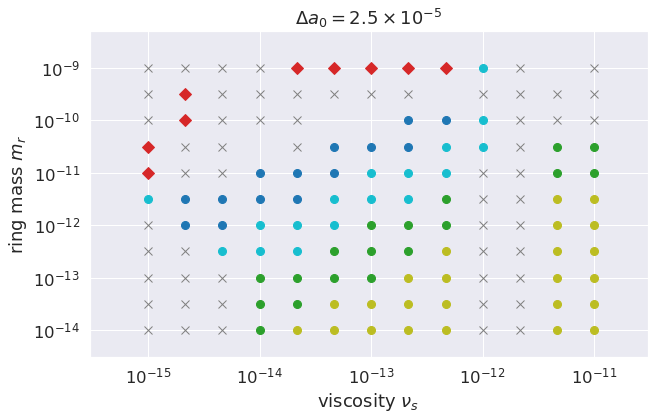

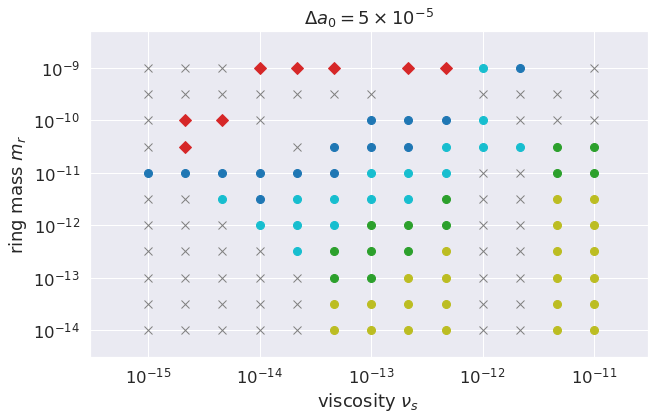

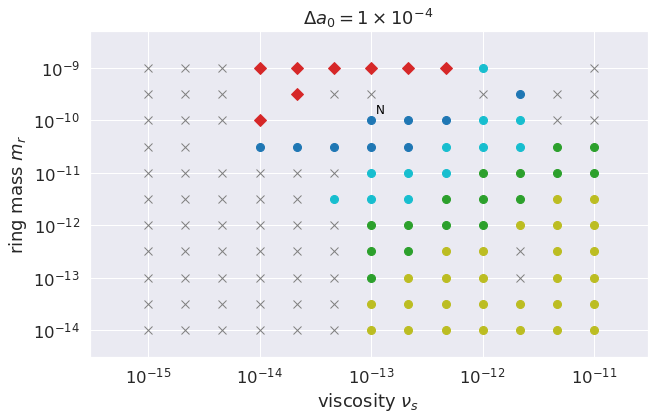

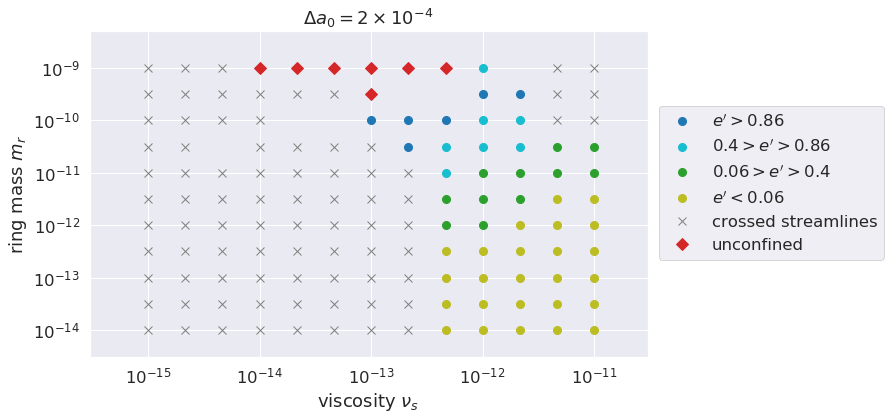

In [14]:
#show grid of simulation outcomes
df = df_results
radial_widths = np.sort(df.radial_width.unique())
e_prime_brackets = [(0.86, r"$e'>0.86$", color_seq[0]),
                    (0.4, r"$0.4>e'>0.86$", color_seq[9]),
                    (0.06, r"$0.06>e'>0.4$", color_seq[2]),
                    (0.0, r"$e' <0.06$", color_seq[8])]
for radial_width in radial_widths:
    idx = (df.radial_width == radial_width)
    dfs = df[idx]
    sns.set(font_scale=1.5, font='DejaVu Sans')
    f, ax = plt.subplots(figsize=(10, 6))
    #dot for self-confining sims
    idx = (dfs.outcome == 'self-confining')
    dfss = dfs[idx]
    for e_prime_bracket, label, color in e_prime_brackets:
        idx = (dfss.e_prime_bracket == e_prime_bracket)
        dfsss = dfss[idx]
        xp = dfsss.shear_viscosity
        yp = dfsss.total_ring_mass
        p = ax.plot(xp, yp, linestyle='none', marker='o', markersize=8, label=label, color=color)
    #x for sims that crossed streamlines
    idx = (dfs.outcome == 'crossed streamlines')
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    p = ax.plot(xp, yp, linestyle='none', marker='x', markersize=8, color='grey', label='crossed streamlines')
    #diamond for simulation complete sims
    idx = (dfs.outcome == 'unconfined')
    dfss = dfs[idx]
    if (len(dfss) > 0):
        xp = dfss.shear_viscosity
        yp = dfss.total_ring_mass
        color = color_seq[3]
        p = ax.plot(xp, yp, linestyle='none', marker='D', markersize=8, color=color, label='unconfined')
    #annotate the nominal sim_id
    idx = (dfs.nominal == True)
    if (idx.sum() > 0):
        dfss = dfs[idx]
        sim_id = str(dfss.sim_id.values[0])
        xp = dfss.shear_viscosity.values[0]
        yp = dfss.total_ring_mass.values[0]
        xy = (1.1*xp, 1.3*yp)
        color = color_seq[3]
        p = ax.annotate('N', xy, fontsize=12, color='black')
    p = ax.set_xscale('log')
    p = ax.set_yscale('log')
    p = ax.set_xlabel(r'viscosity $\nu_s$')
    p = ax.set_ylabel(r'ring mass $m_r$')
    if (radial_width == 2.5e-5):
        title = r'$\Delta a_0 = 2.5\times10^{-5}$'
        file = 'figs/sim_grid_da_0p000025.pdf'
    if (radial_width == 5.0e-5):
        title = r'$\Delta a_0 = 5\times10^{-5}$'
        file = 'figs/sim_grid_da_0p00005.pdf'
    if (radial_width == 1.0e-4):
        title = r'$\Delta a_0 = 1\times10^{-4}$'
        file = 'figs/sim_grid_da_0p0001.pdf'
    if (radial_width == 2.0e-4):
        title = r'$\Delta a_0 = 2\times10^{-4}$'
        file = 'figs/sim_grid_da_0p0002.pdf'
    p = ax.set_title(title)
    p = ax.set_xlim(3.0e-16, 3.0e-11)
    p = ax.set_ylim(3.0e-15, 5.0e-9)
    if (radial_width == radial_widths[-1]):
        p = ax.legend(loc=(1.02, 0.3))
    print 'file = ', file, '    radial_width = ', radial_width
    plt.savefig(file, bbox_inches='tight')

In [15]:
#conda install scikit-learn
#conda install pyarrow

number of e_prime_bracket=0.86 sims =  43
number of sims plotted =  5


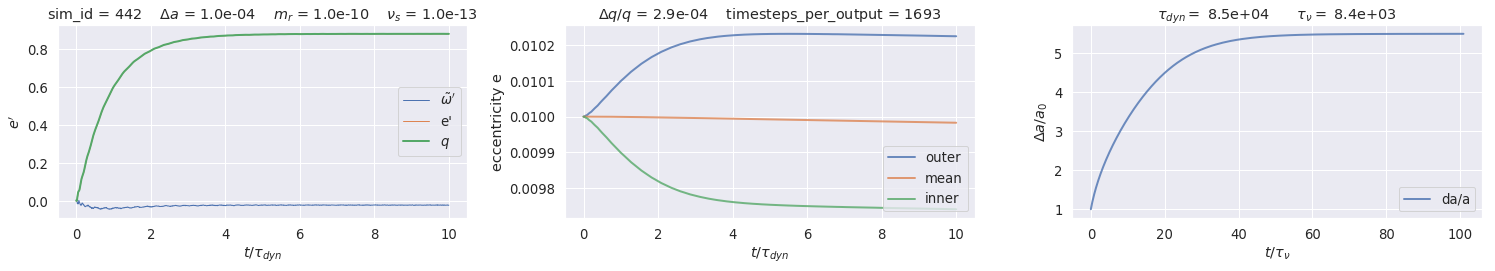

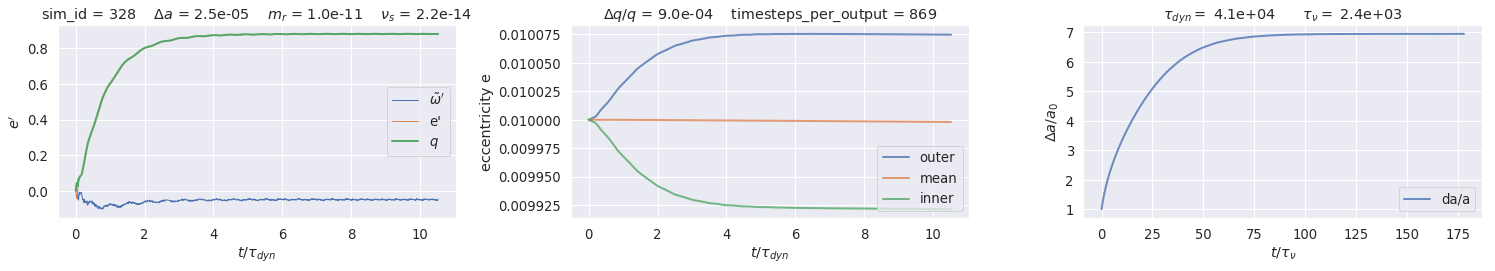

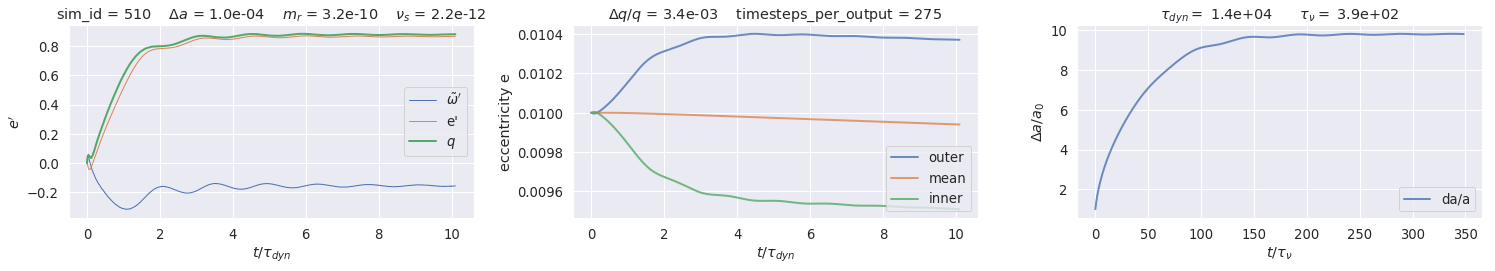

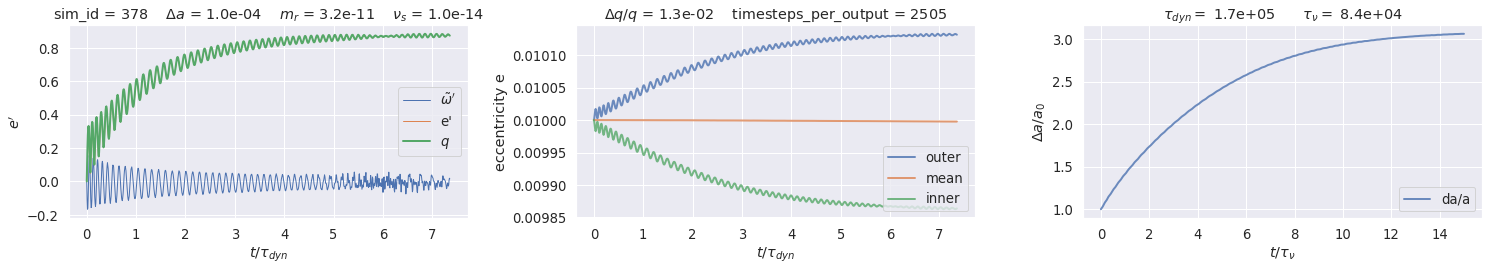

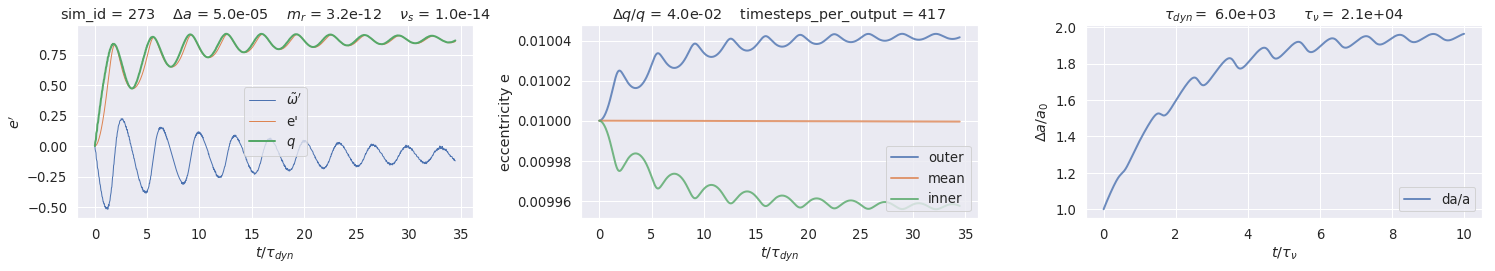

In [16]:
#generate summary plots for sample of e_prime_bracket=0.8 sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.86
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.86 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.4 sims =  53
number of sims plotted =  5


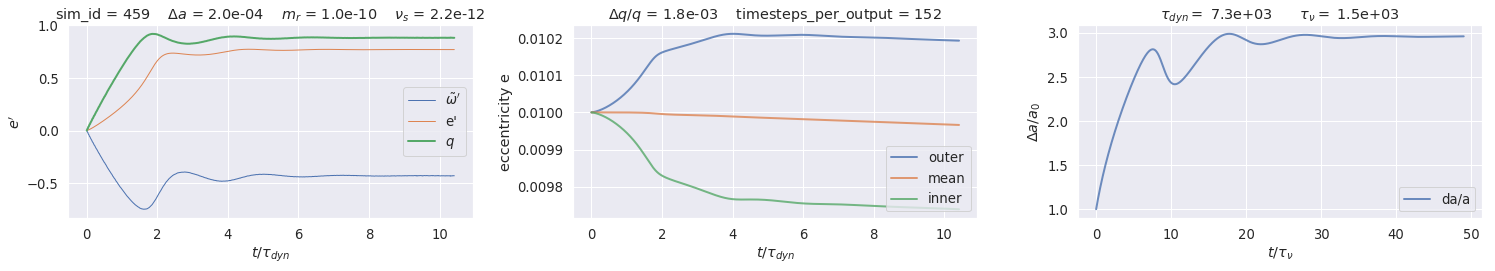

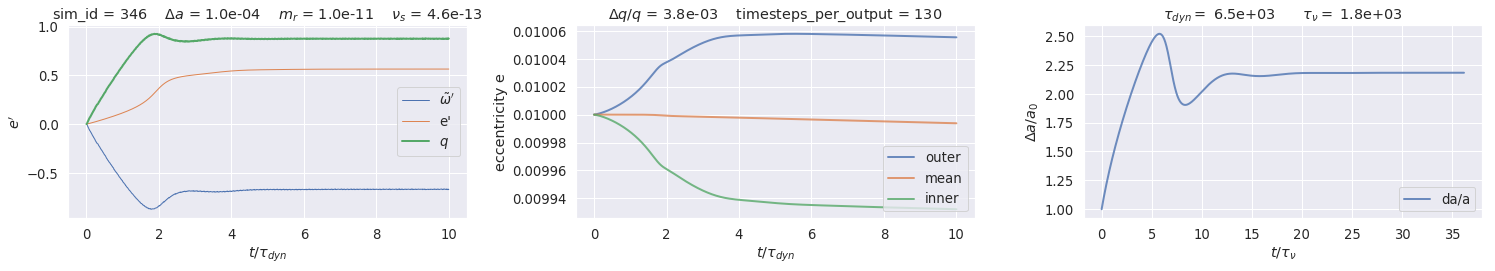

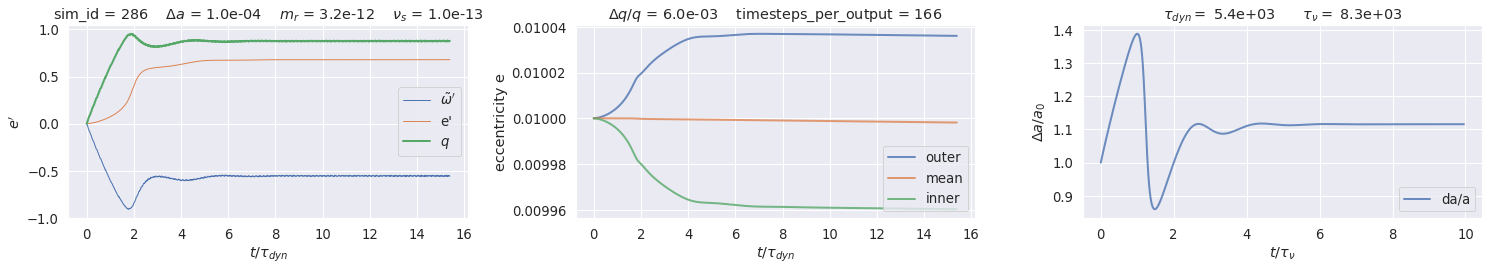

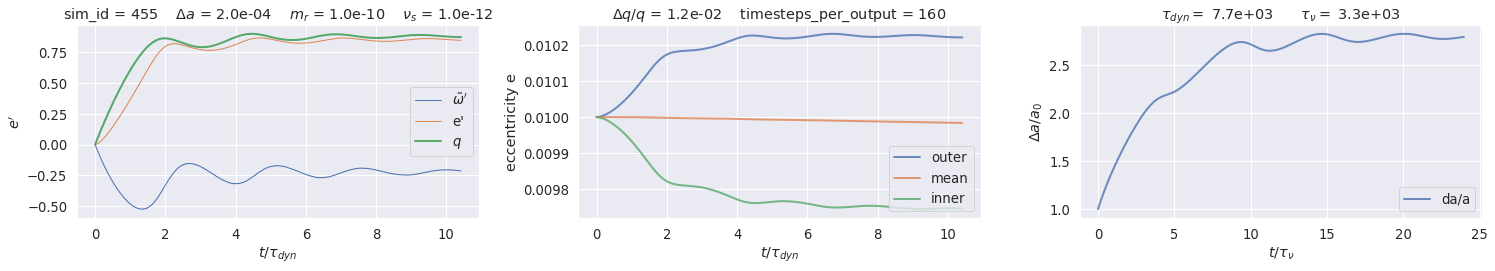

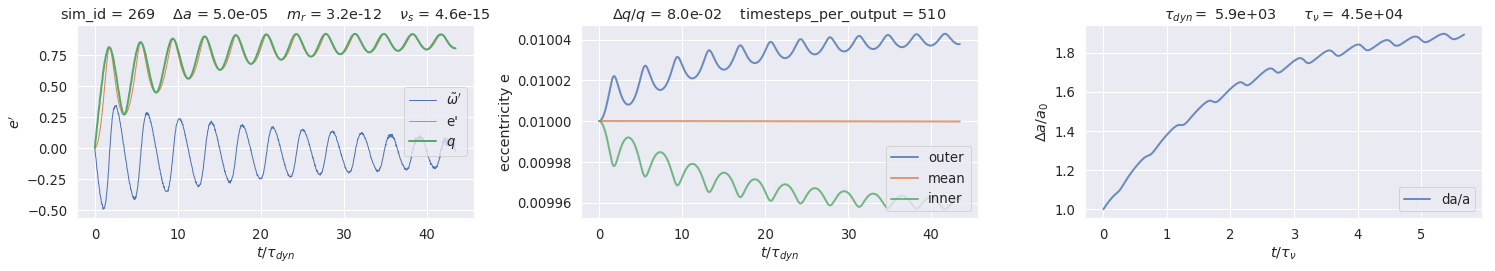

In [17]:
#generate summary plots for sample of e_prime_bracket=0.4 (ie 0.4<e'<0.86) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.4
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.4 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.06 sims =  58
number of sims plotted =  5


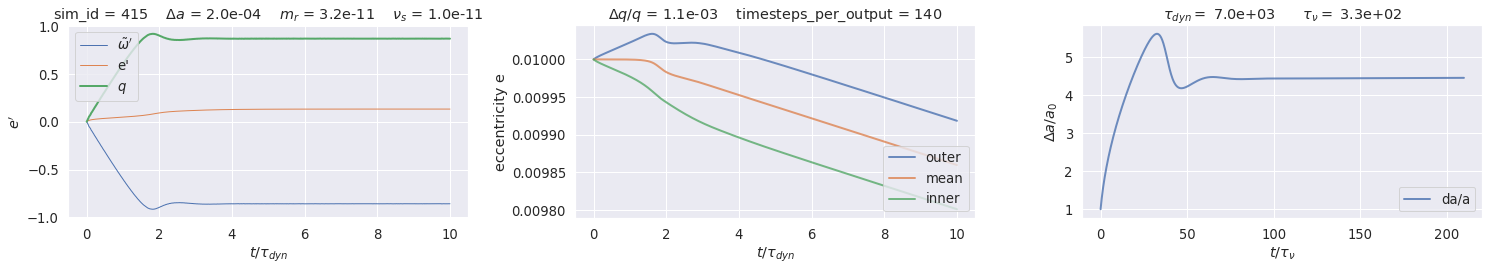

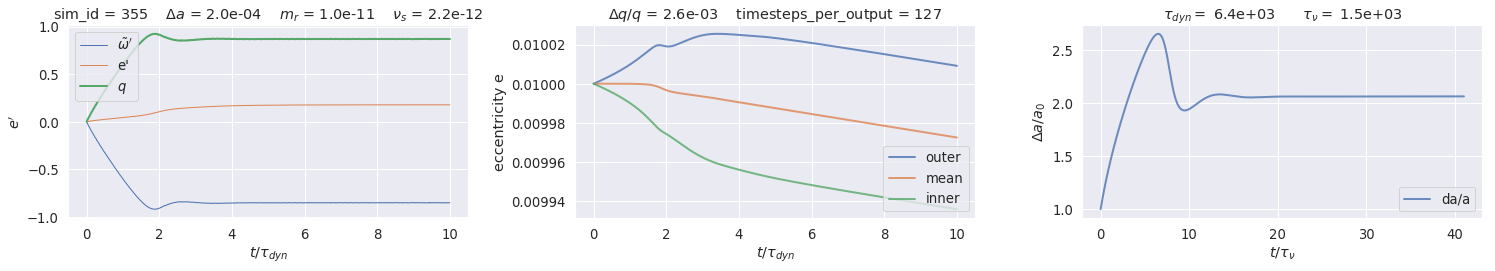

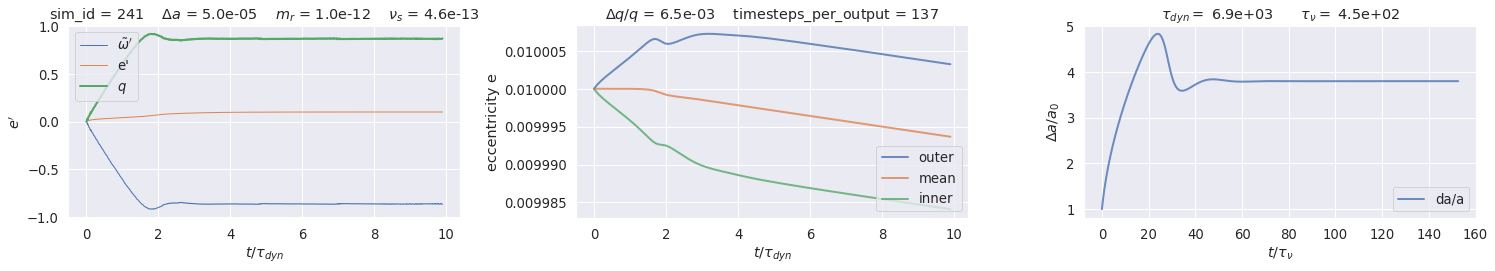

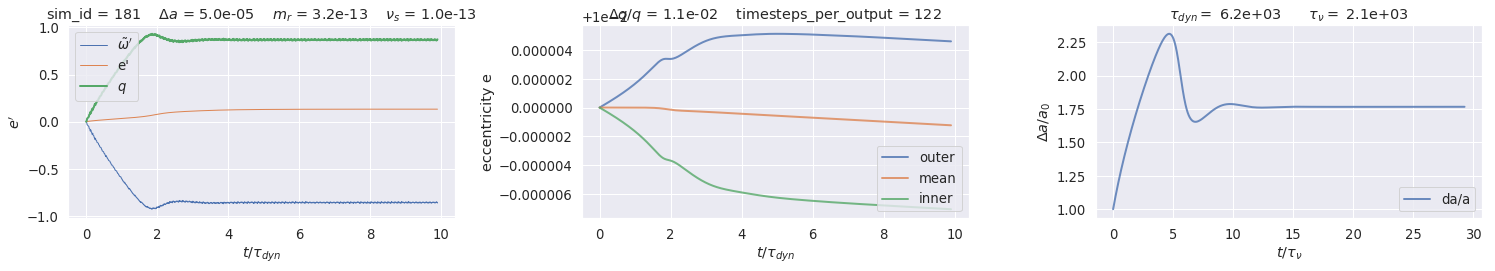

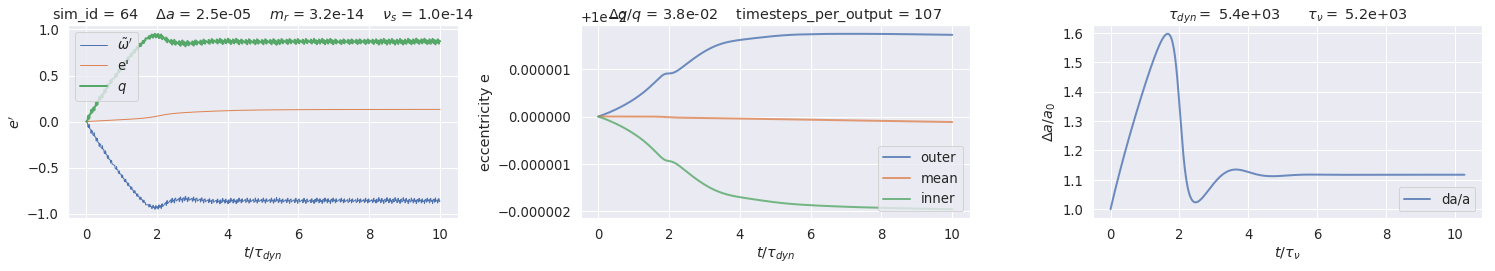

In [18]:
#generate summary plots for sample of e_prime_bracket=0.06 (ie 0.06<e'<0.4) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.06
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.06 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of e_prime_bracket=0.0 sims =  100
number of sims plotted =  5


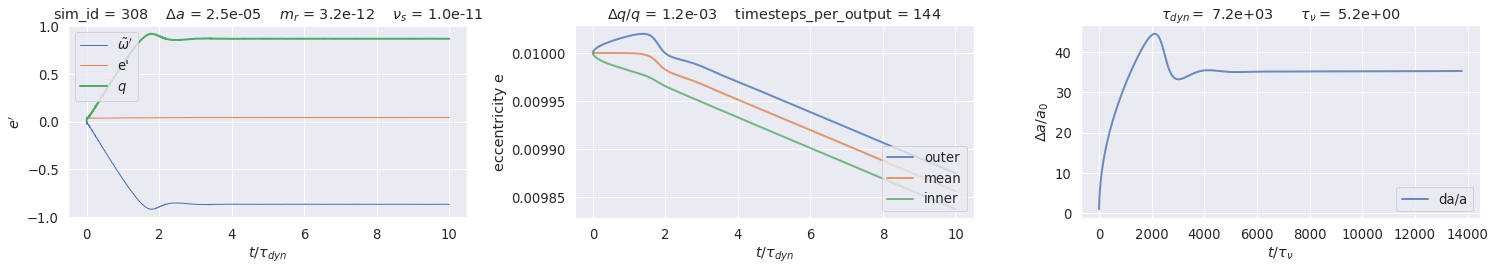

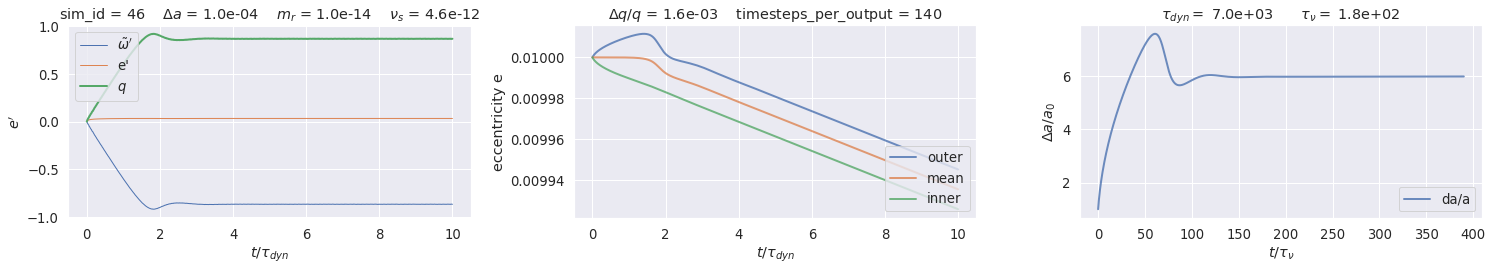

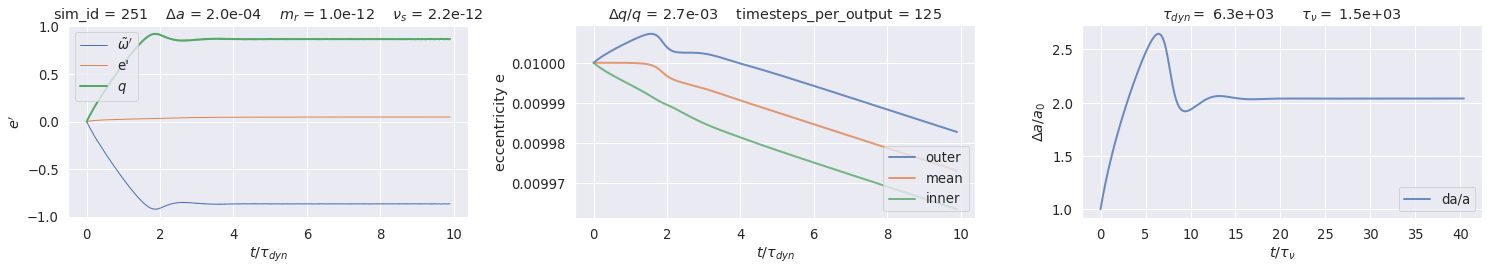

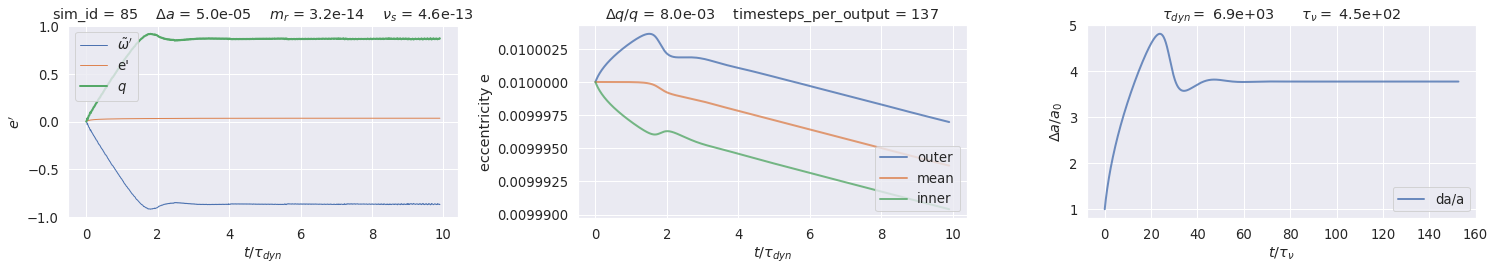

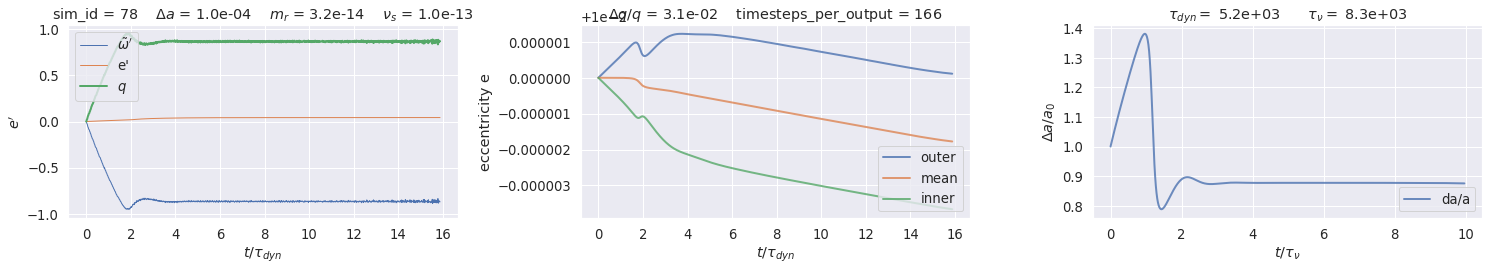

In [19]:
#generate summary plots for sample of e_prime_bracket=0.0 (ie 0.0<e'<0.06) sims sorted by delta_q_over_q
df = df_results
xlim = (-1, 11)
N_plots = 5
e_prime_bracket = 0.0
idx = (df.outcome == 'self-confining') & (df.e_prime_bracket == e_prime_bracket)
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of e_prime_bracket=0.0 sims = ', len(dfs)
idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
dfss = dfs.loc[idx]
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

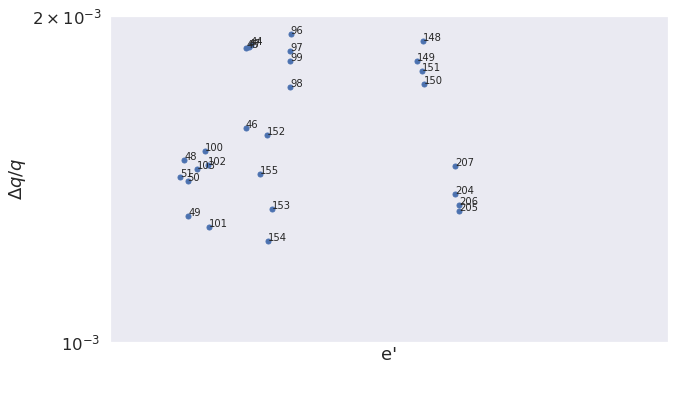

In [20]:
#select low delta_q_over_q sims having a variety of e_prime 
df = df_results
delta_q_over_q_max = 0.0029
sim_ids = [338, 355, 242, 303, 247, 307, 251, 309, 255, 199, 258, 203, 147, 150, 48]
idx = (df.outcome == 'self-confining')
df = df[idx]
sns.set(font_scale=1.5, font='DejaVu Sans')
fig, ax = plt.subplots(figsize=(10, 6))
xp = df.e_prime
yp = df.delta_q_over_q
p = ax.plot(xp, yp, linestyle='none', marker='o', markersize=5)
p = ax.axhline(delta_q_over_q_max, linestyle='dashed', color=color_seq[1])
for idx, row in df.iterrows():
    xy = (row.e_prime, row.delta_q_over_q)
    s = str(int(row.sim_id))
    p = ax.annotate(s, xy=xy, fontsize=10)
p = ax.set_ylabel(r'$\Delta q/q$')
p = ax.set_xlabel("e'")
p = ax.set_xscale('log')
p = ax.set_yscale('log')
#p = ax.set_xlim(0.03, 1.0)
#p = ax.set_ylim(0.0005, 0.005)
p = ax.set_xlim(0.032, 0.034)
p = ax.set_ylim(0.001, 0.002)
sim_ids = [51, 49, 101, 154, 205, 147, 98, 150, 205, 201, 259, 199, 255, 308, 251, 307, 362, 
    303, 359, 415, 355, 411, 351, 407, 346, 403, 459, 442]

In [21]:
#ringlet eccentricity gradients
ringlets = {'Maxwell':0.663, 'Titan':0.425, 'Laplace':0.039, 'Huygens':0.012}

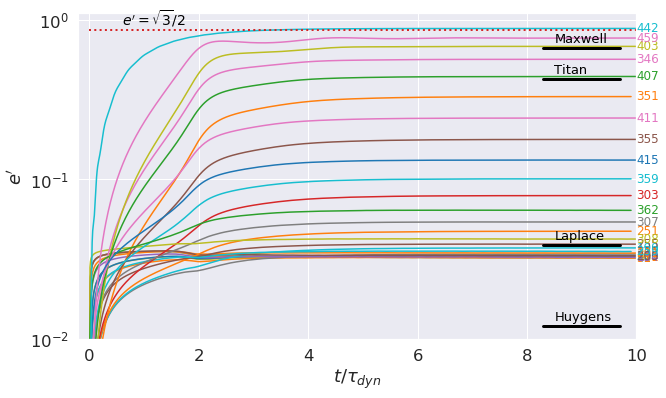

In [22]:
#plot e' vs time for selected sim_ids
df = df_results
idx = (df.sim_id.isin(sim_ids))
df = df[idx]
#df = df.sort_values('e_prime')
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
for idx, row in df.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    xp = times_dynamical
    yp = e_prime
    label = str(row.sim_id)
    color = color_seq[idx%len(color_seq)]
    p = ax.plot(xp, yp, linestyle='-', linewidth=1.5, color=color, label=label)
    xy=(10.0, 0.95*row.e_prime)
    s = str(row.sim_id)
    p = ax.annotate(s, xy=xy, fontsize=12, color=color)
for ringlet, e_prime in ringlets.iteritems():
    xp = np.array([8.3, 9.7])
    yp = xp*0 + e_prime
    color = 'black'
    p = ax.plot(xp, yp, linestyle='-', linewidth=3, color=color)
    xy = (8.5, 1.08*e_prime)
    p = ax.annotate(ringlet, xy, color=color, fontsize=13)
xp = np.array([0, 10])
yp = xp*0 + np.sqrt(3.0)/2.0
color = color_seq[3]
p = ax.plot(xp, yp, linestyle='dotted', linewidth=2, color=color)
p = ax.annotate(r"$e'=\sqrt{3}/2$", (0.60, 0.92), color='black', fontsize=14)
p = ax.set_ylabel(r"$e'$")
p = ax.set_xlabel(r'$t/\tau_{dyn}$')
p = ax.set_yscale('log')
p = ax.set_ylim(0.01, 1.1)
p = ax.set_xlim(-0.2, 10.0)
file = 'figs/e_prime_selected.pdf'
plt.savefig(file, bbox_inches='tight')

number of unconfined sims =  32
number of sims plotted =  30


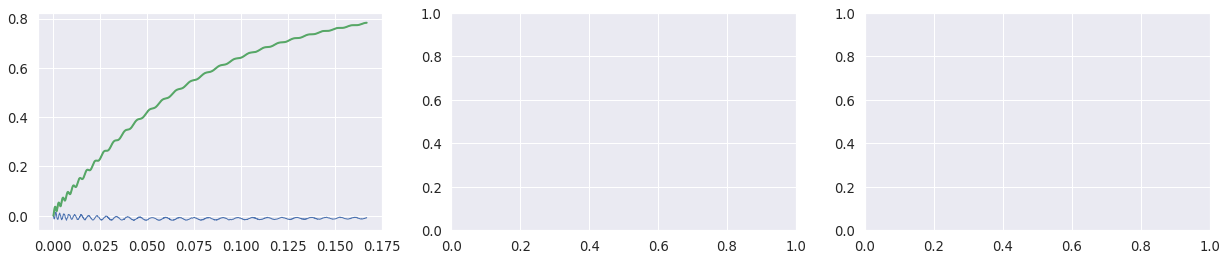

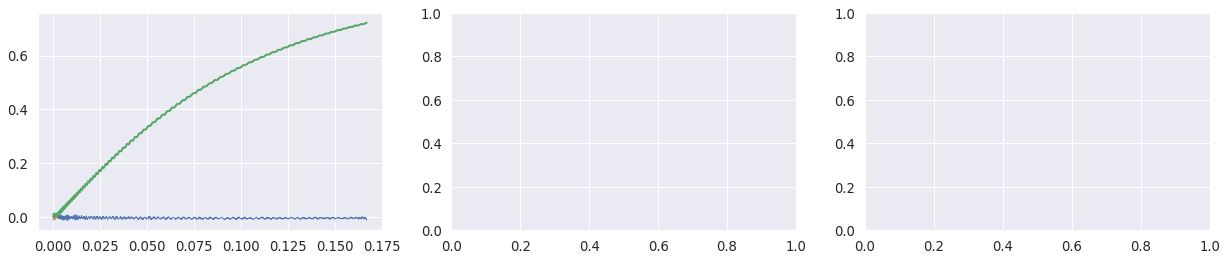

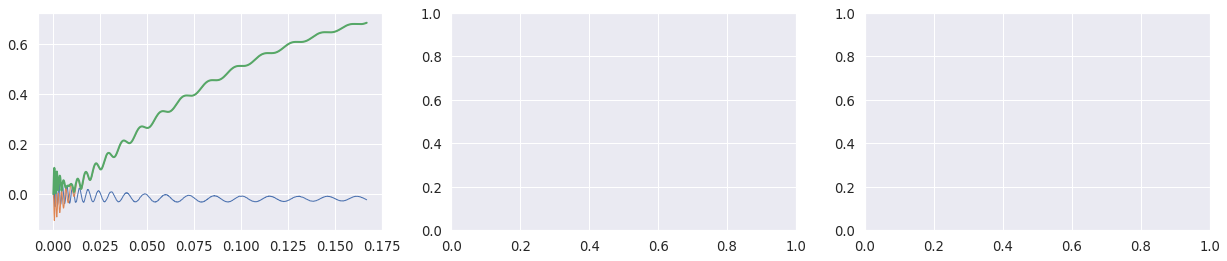

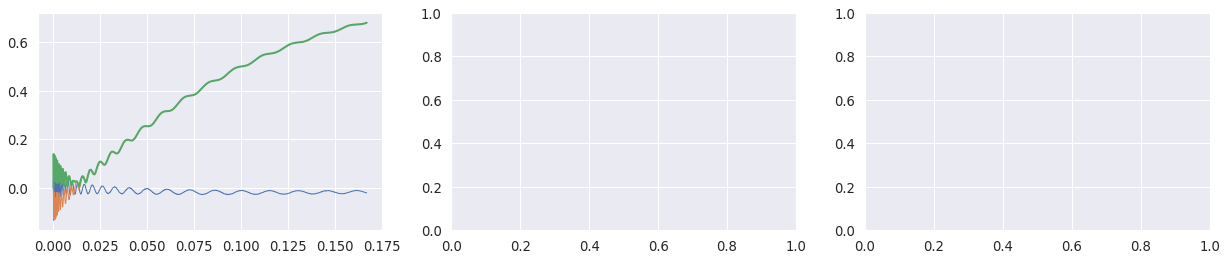

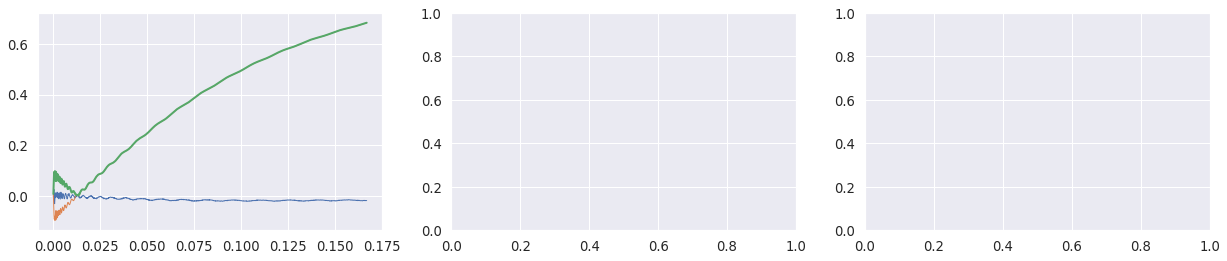

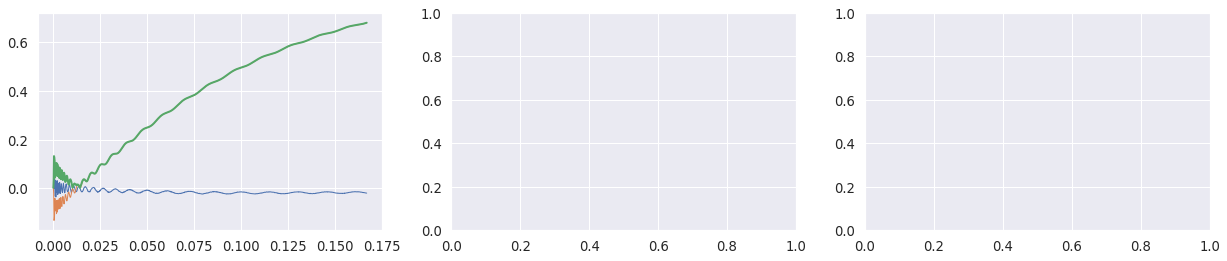

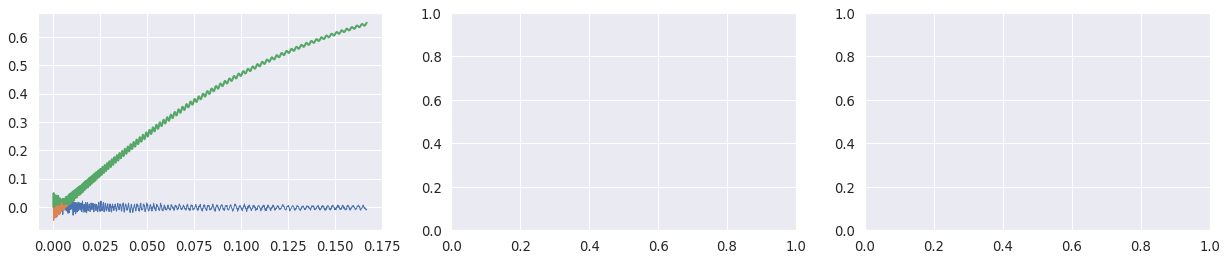

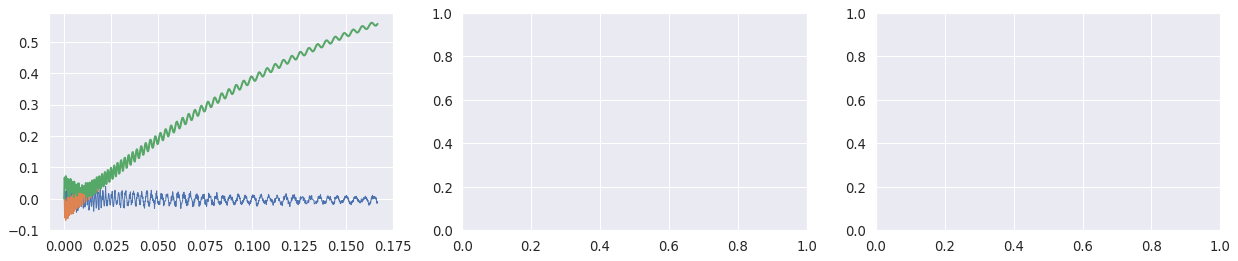

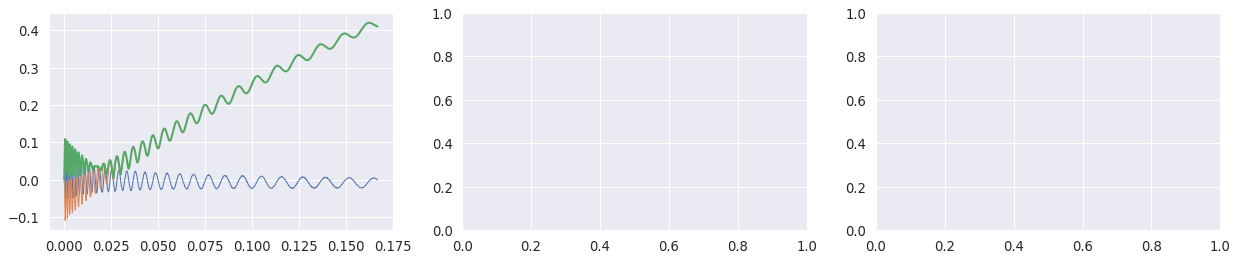

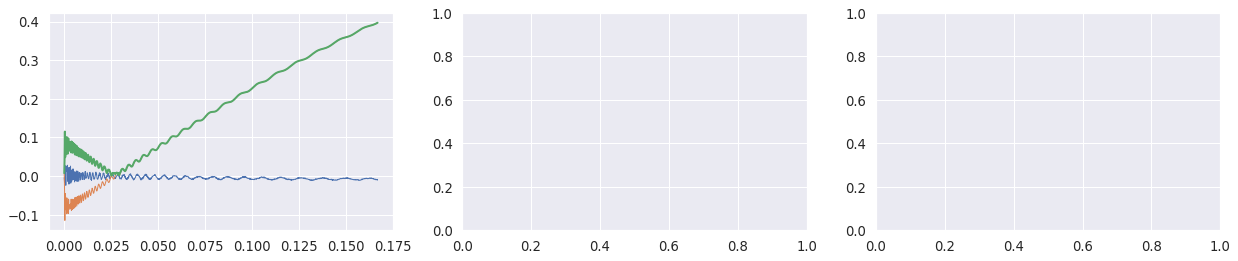

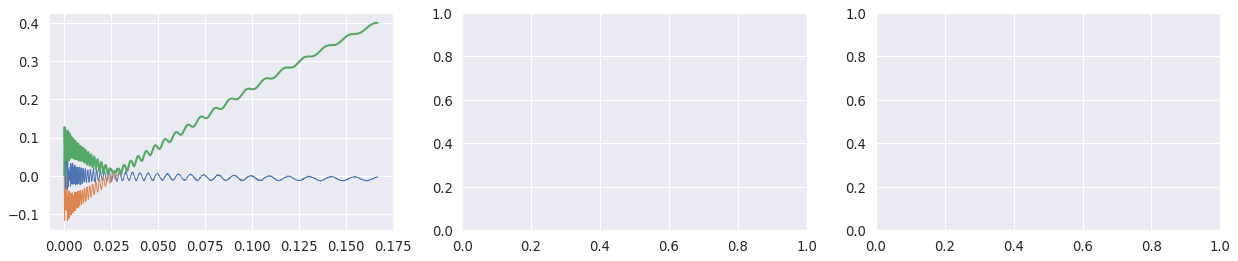

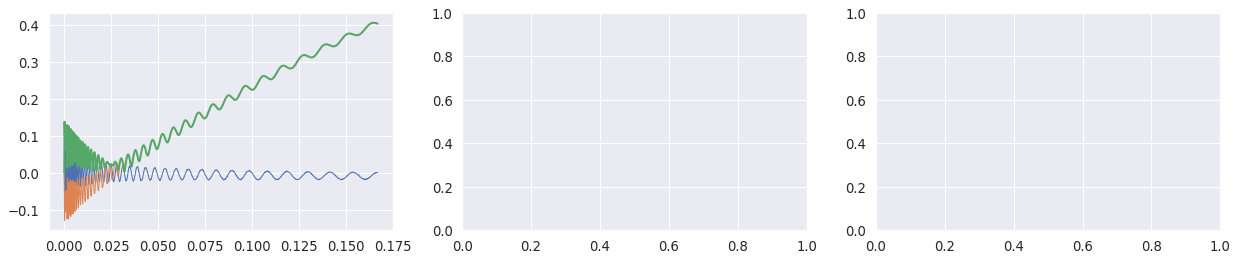

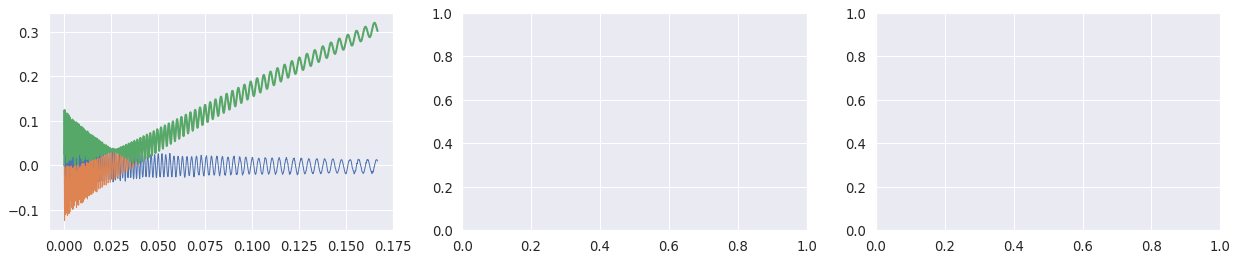

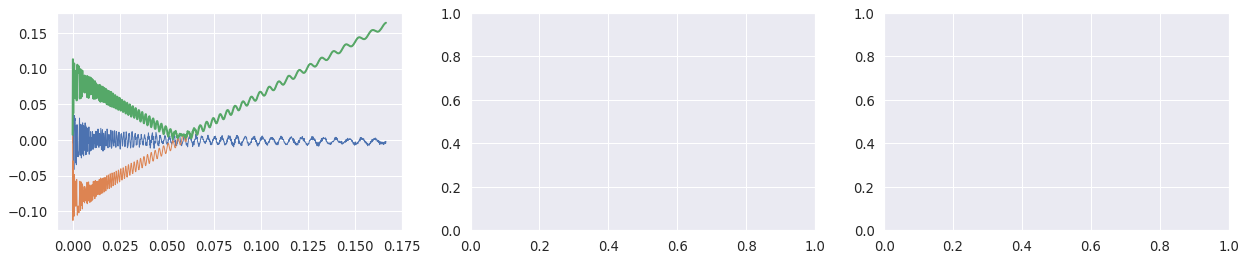

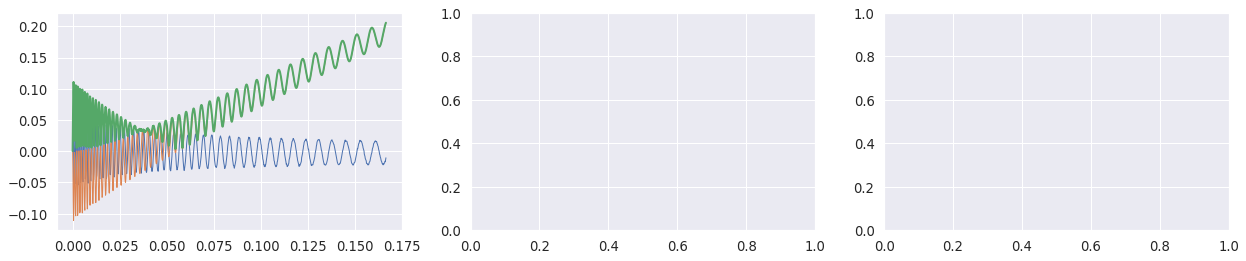

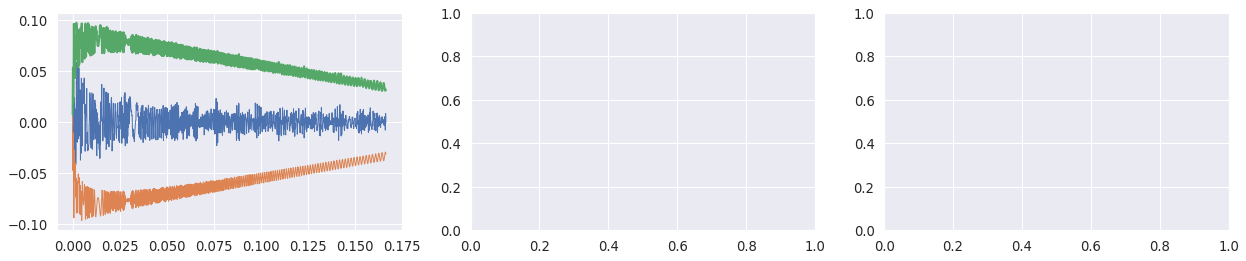

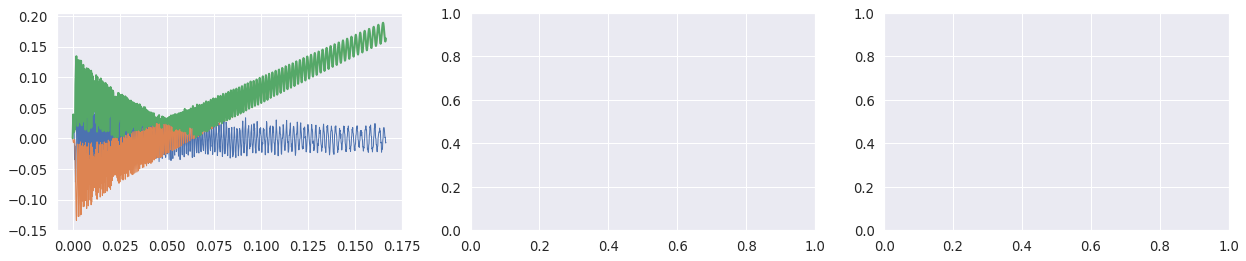

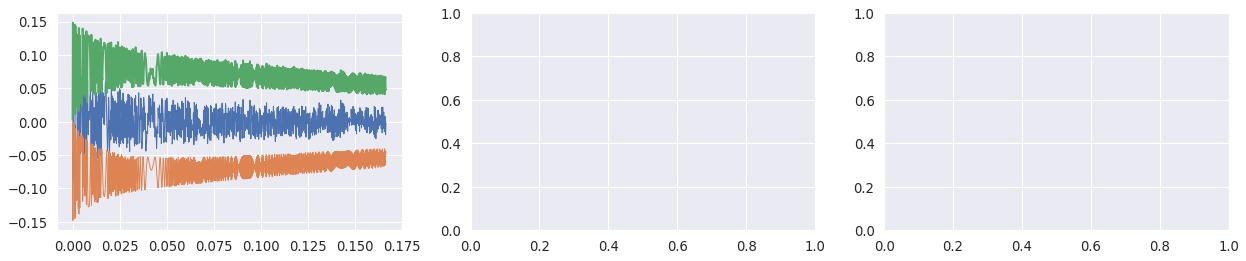

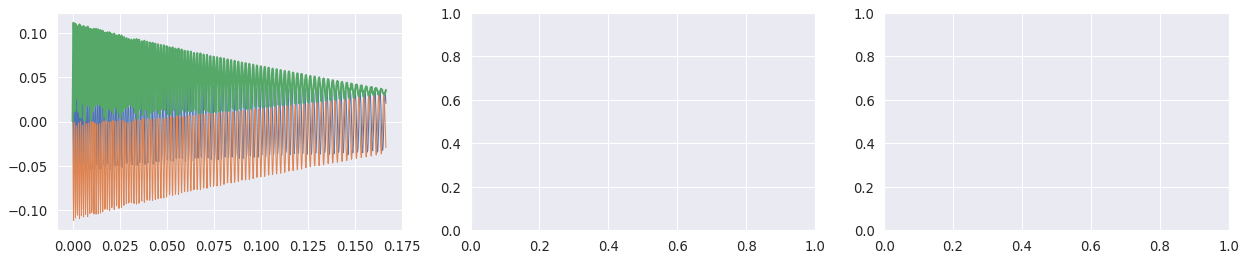

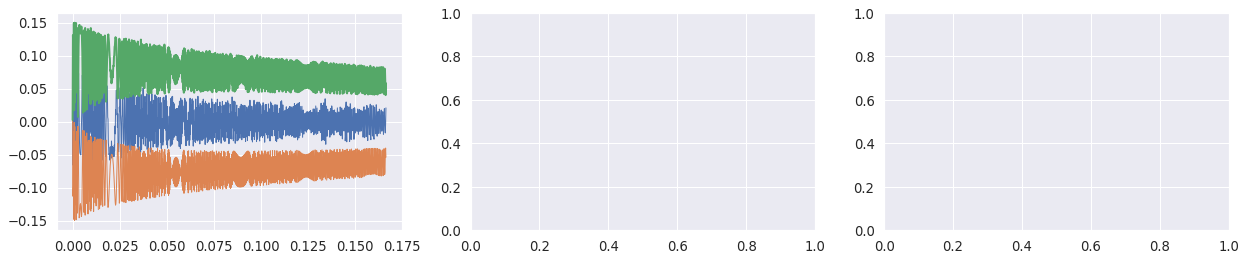

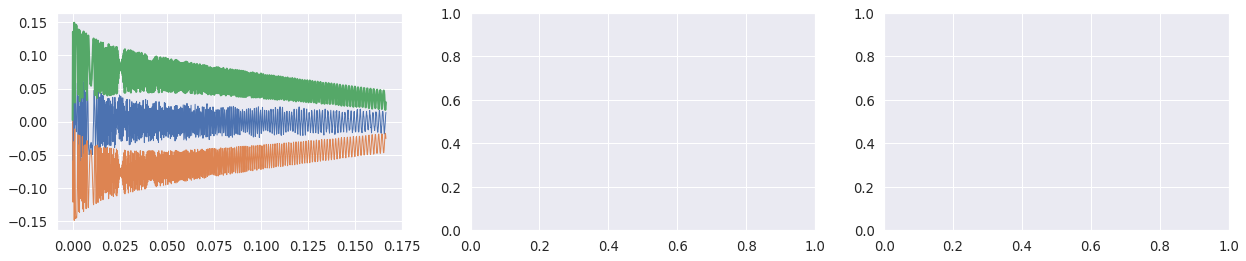

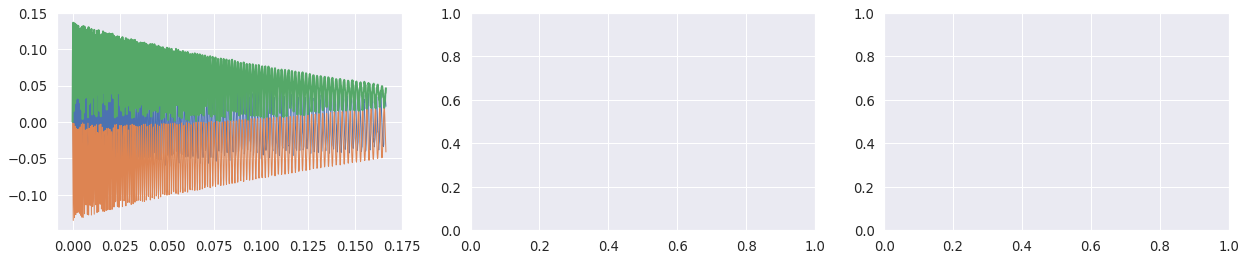

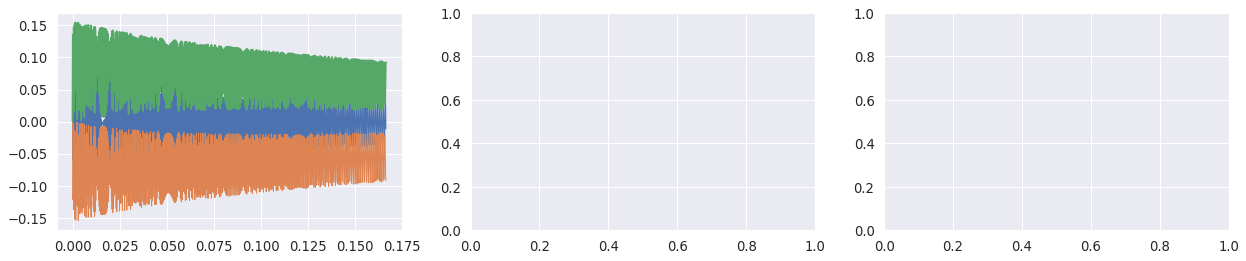

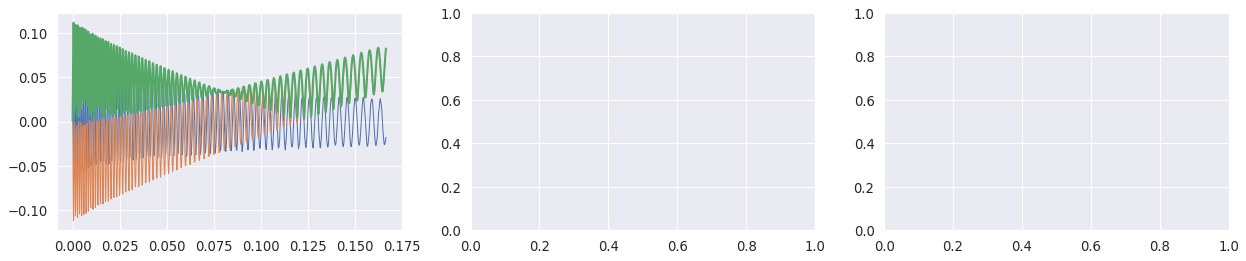

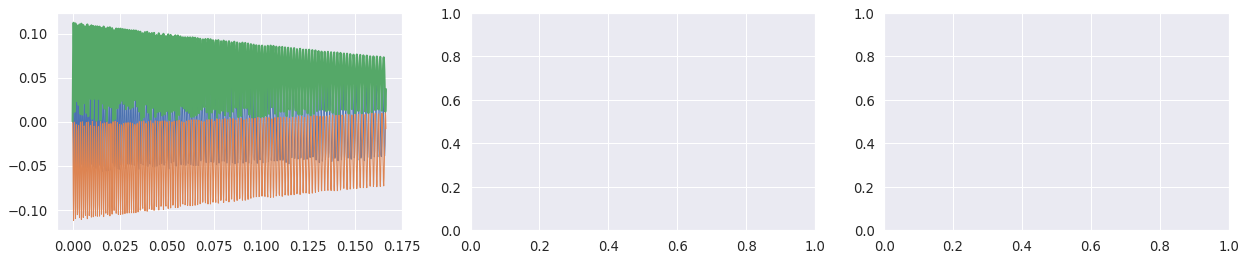

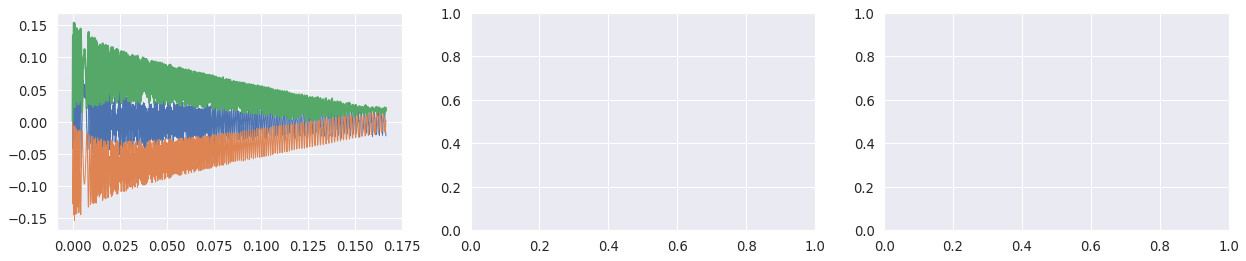

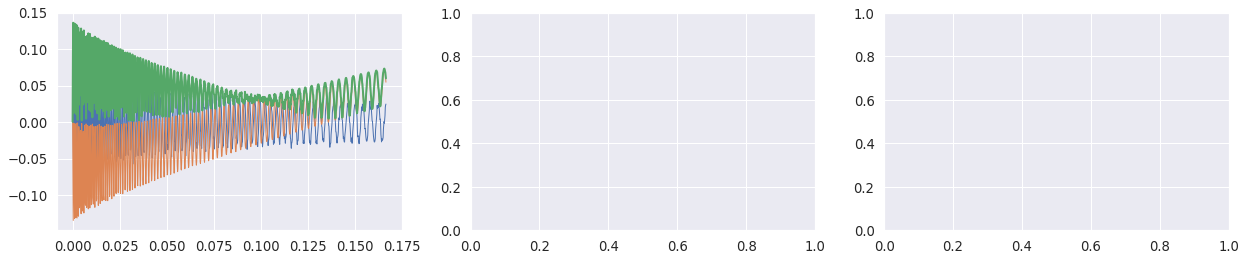

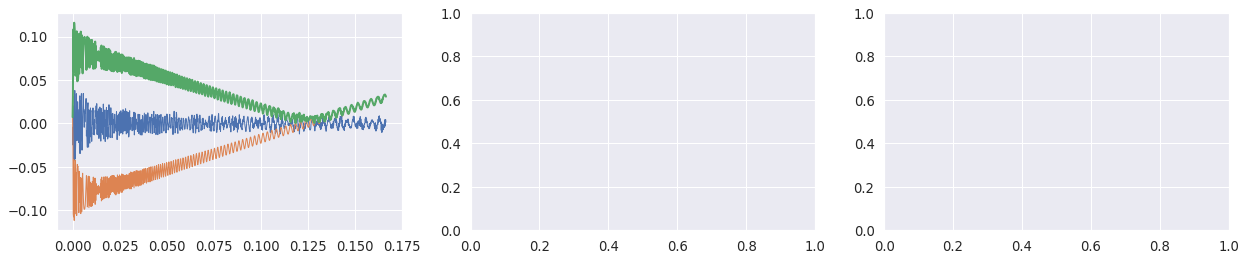

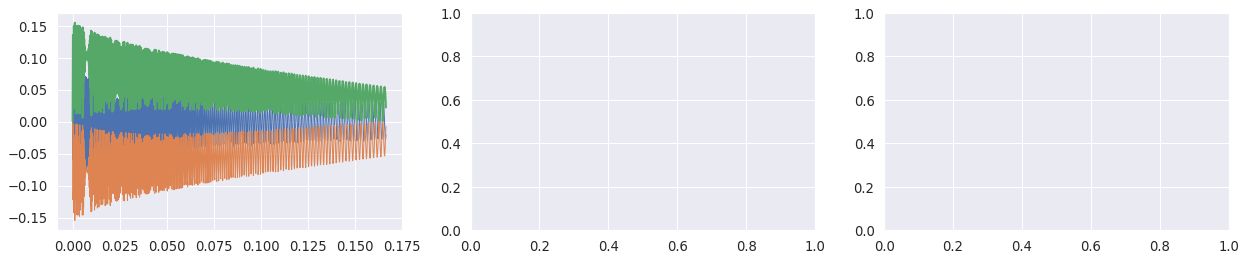

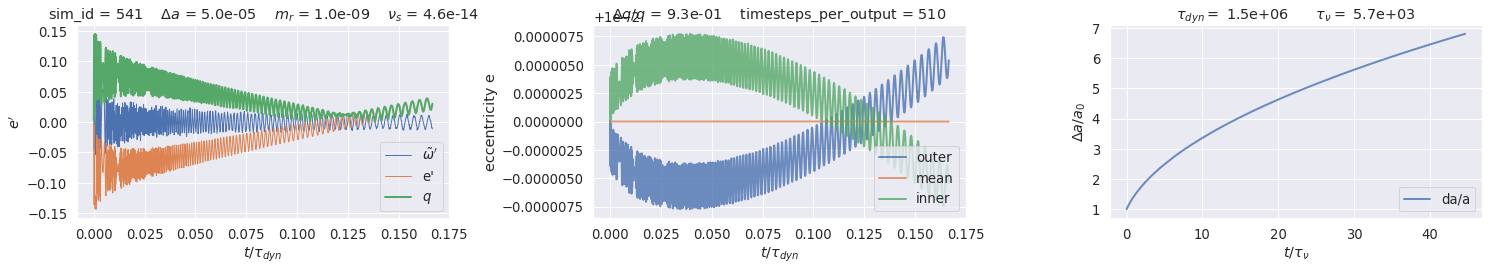

In [23]:
#generate summary plots for all unconfined sims sorted by delta_q_over_q
df = df_results
N_plots = 30
xlim = (-1, 11)
idx = (df.outcome == 'unconfined')
dfs = df[idx].copy()
dfs = dfs.sort_values('delta_q_over_q').reset_index(drop=True)
N_unconfined = len(dfs)
print 'number of unconfined sims = ', N_unconfined
if (N_unconfined > 0):
    idx = np.linspace(0, len(dfs)-1, num=N_plots).astype(int)
    dfss = dfs.loc[idx]
    print 'number of sims plotted = ', len(dfss)
    for idx, row in dfss.iterrows():
        #read simulation input and revised output
        execfile('inputs.py')
        path = row.path
        r, t, vr, vt, times, monitor = restore_output(path)
        dynamical_timescale = row.dynamical_timescale
        times_dynamical = times/dynamical_timescale
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
        da_init = da[0]
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        #create grid of plots
        sns.set(font_scale=1.2, font='DejaVu Sans')
        fig, axs = plt.subplots(1, 3, figsize=(21, 4))
        #plot e_prime wt_prime and q versus time
        ax = axs[0]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
        y = e_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
        y = q
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
        sim_id = row.sim_id
        radial_width = row.radial_width
        total_ring_mass = row.total_ring_mass
        shear_viscosity = row.shear_viscosity
        title = 'sim_id = ' + str(sim_id)
        title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()

number of sims plotted =  10


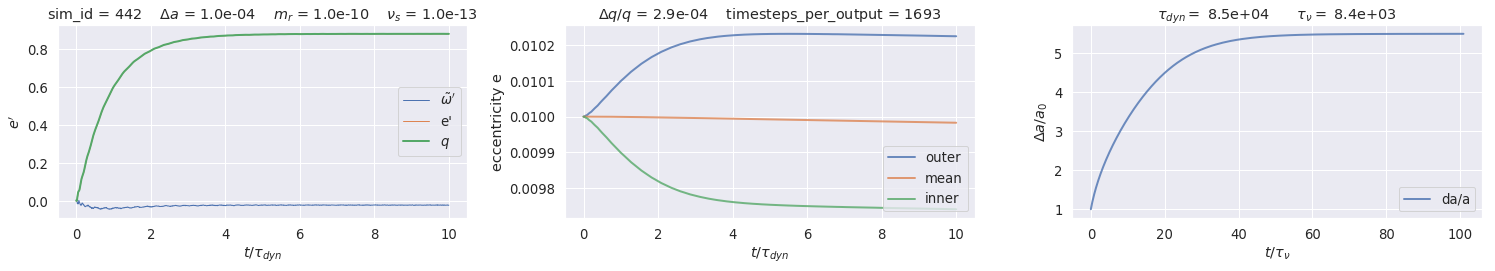

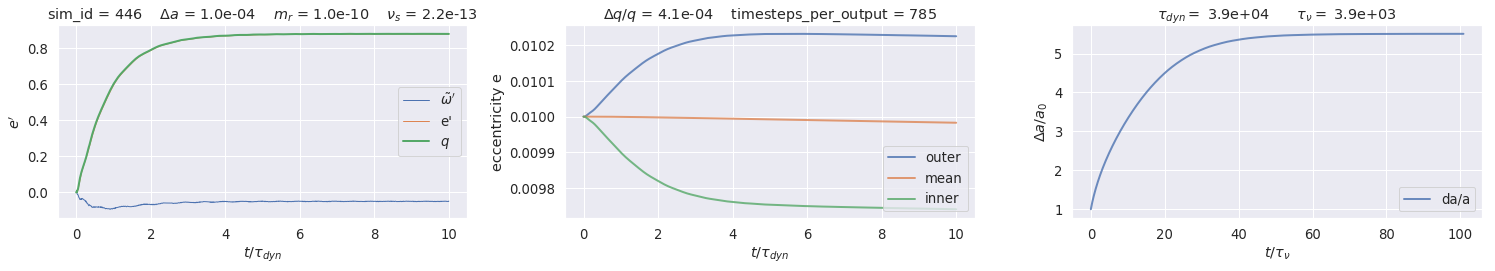

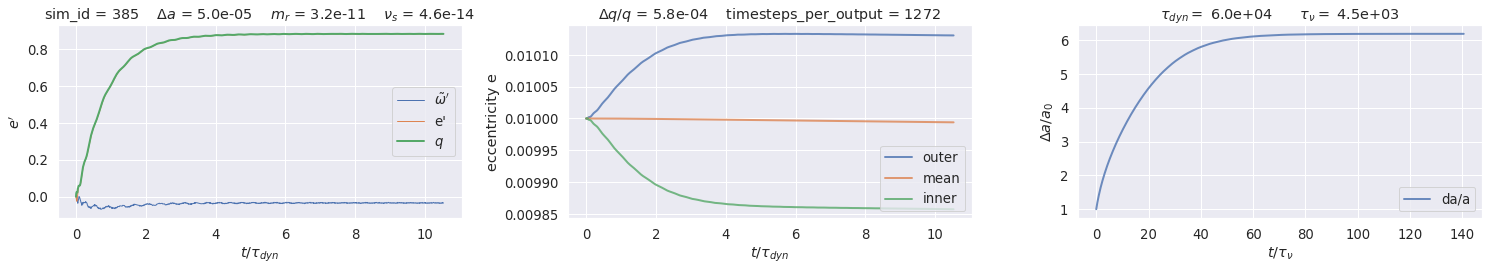

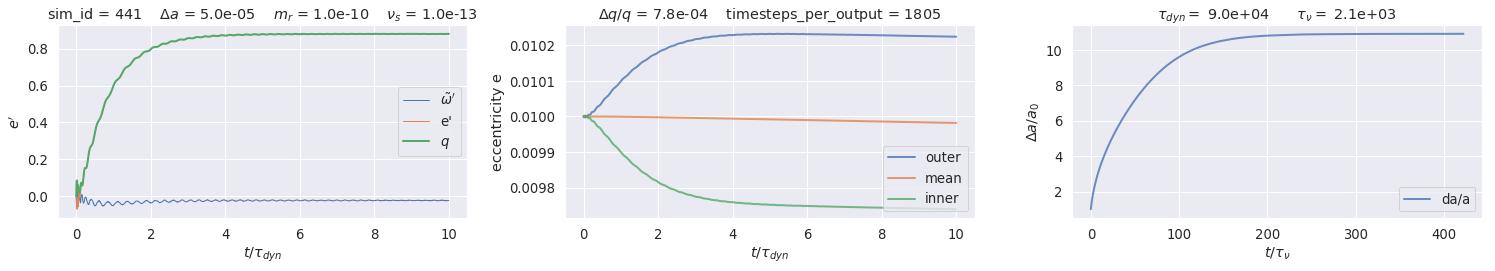

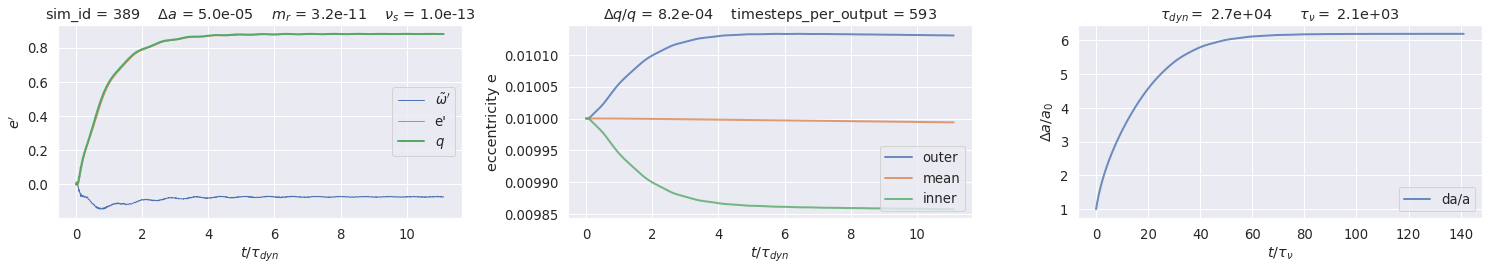

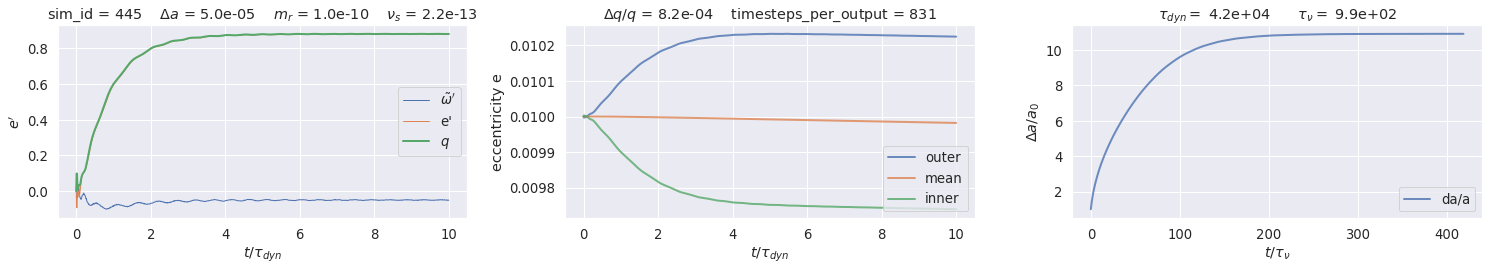

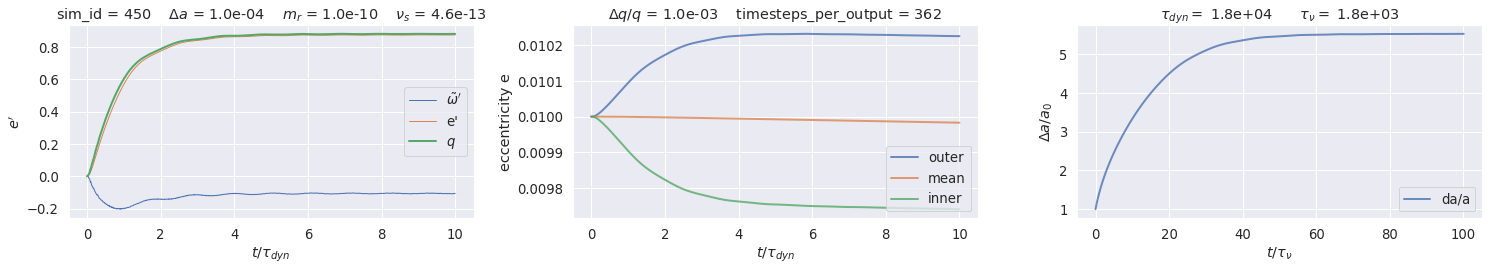

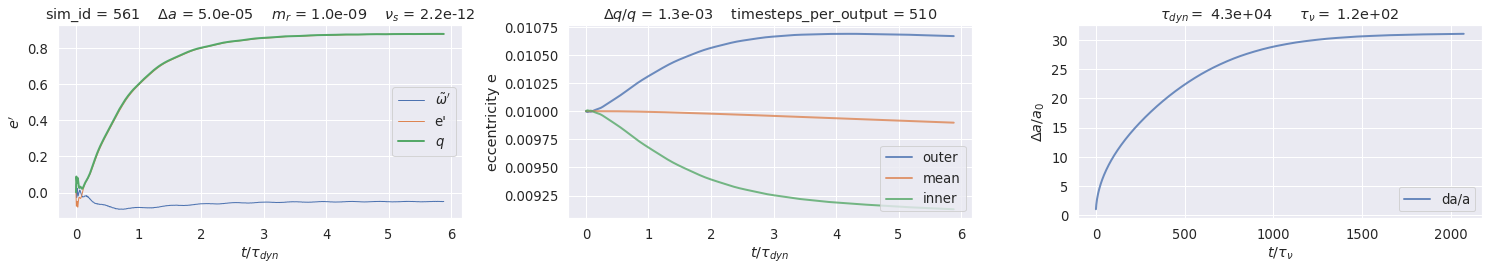

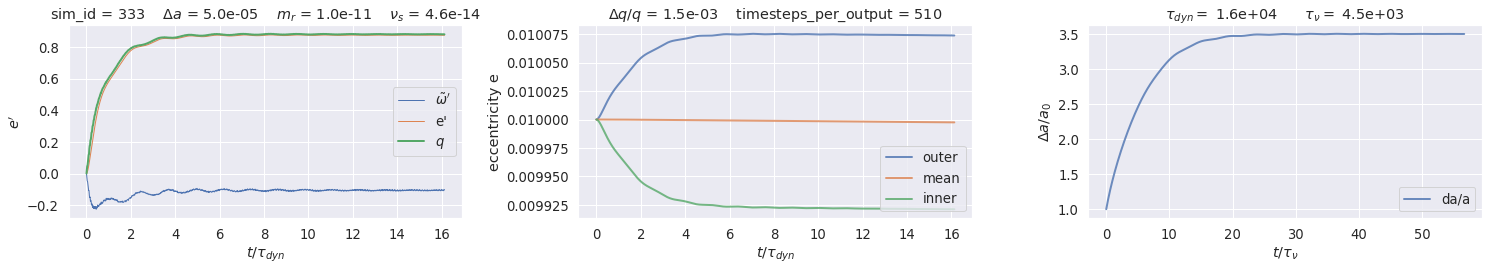

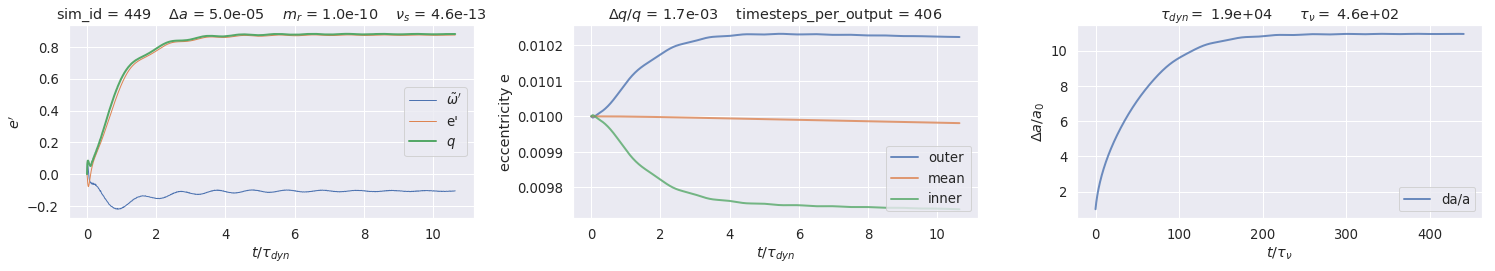

In [24]:
#find most nominal sim
df = df_results
xlim = (-1, 11)
idx = (df.outcome == 'self-confining')
dfs = df[idx].copy()
idx = (dfs.radial_width > 3.0e-5) & (dfs.radial_width < 1.5e-4) & (dfs.e_prime_bracket > 0.7) \
    & (dfs.delta_q_over_q < 0.003)
dfss = dfs[idx]
dfss = dfss.sort_values('delta_q_over_q').reset_index(drop=True)
print 'number of sims plotted = ', len(dfss)
for idx, row in dfss.iterrows():
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, monitor = restore_output(path)
    dynamical_timescale = row.dynamical_timescale
    times_dynamical = times/dynamical_timescale
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, t, vr, vt, a, e, wt, J2, Rp)
    da_init = da[0]
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    #create grid of plots
    sns.set(font_scale=1.2, font='DejaVu Sans')
    fig, axs = plt.subplots(1, 3, figsize=(21, 4))
    #plot e_prime wt_prime and q versus time
    ax = axs[0]
    x = times_dynamical
    y = wt_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
    y = e_prime
    p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
    y = q
    p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
    #p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
    sim_id = row.sim_id
    radial_width = row.radial_width
    total_ring_mass = row.total_ring_mass
    shear_viscosity = row.shear_viscosity
    title = 'sim_id = ' + str(sim_id)
    title += r'    $\Delta a$ = ' + '{:.1e}'.format(radial_width)
    title += r'    $m_r$ = ' + '{:.1e}'.format(total_ring_mass)
    title += r'    $\nu_s$ = ' + '{:.1e}'.format(shear_viscosity)
    p = ax.set_title(title)
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    p = ax.set_ylabel(r"$e'$")
    #p = ax.set_xlim(xlim)
    p = ax.legend()
    p = plt.tight_layout()
    #plot streamline's e-evolution
    ax = axs[1]
    x = times_dynamical
    y = e_outer
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
    y = e_mean
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
    y = e_inner
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
    p = ax.set_ylabel('eccentricity e')
    p = ax.set_xlabel(r'$t/\tau_{dyn}$')
    delta_q_over_q = row.delta_q_over_q
    timesteps_per_output = row.timesteps_per_output
    title = r'$\Delta q/q$ = ' + '{:.1e}'.format(delta_q_over_q)
    title += r'    timesteps_per_output = ' + str(timesteps_per_output)
    p = ax.set_title(title)
    #p = ax.set_xlim(xlim)
    p = ax.legend(loc='lower right')
    #plot da vs times
    ax = axs[2]
    viscous_timescale = row.viscous_timescale
    times_viscous = times/viscous_timescale
    x = times_viscous
    da0 = da[0]
    y = da/da0
    p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='da/a')
    p = ax.set_ylabel(r'$\Delta a/a_0$')
    p = ax.set_xlabel(r'$t/\tau_{\nu}$')
    title =  r'$\tau_{dyn} = $ ' + '{:.1e}'.format(dynamical_timescale)
    title += r'      $\tau_{\nu} = $ ' + '{:.1e}'.format(viscous_timescale)
    p = ax.set_title(title)
    p = ax.legend(loc='lower right')
    p = plt.tight_layout()


In [25]:
#done
time_exec_min = (tm.time() - t_start)/60
print 'time_exec_min = ', time_exec_min

time_exec_min =  3.05884949764
